<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeAutomatizado/blob/2022-2/notebooks/3a_validacion_cruzada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Selección de modelos
En esta libreta evaluaremos modelos de clasificación usando valación cruzada.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
  
from sklearn.metrics import average_precision_score, accuracy_score
from sklearn.metrics import precision_score, recall_score

## Validación cruzada

Definimos la función para realizar validación cruzada aleatoria

In [2]:
def vc_aleatorio(X, y, r = 100, t_ent=0.8):
  n = X.shape[0]
  for i in range(r):
    perm = np.random.permutation(n)
    
    X = X[perm]
    y = y[perm]
    
    X_ent = X[:int(X.shape[0] * t_ent)]
    y_ent = y[:int(X.shape[0] * t_ent)]

    X_val = X[int(X.shape[0] * t_ent):]
    y_val = y[int(X.shape[0] * t_ent):]
    
    yield i, X_ent, y_ent, X_val, y_val

In [3]:
X_ = np.random.rand(10)
y_ = np.random.rand(10)
print(X_, y_)

[0.8903078  0.66844216 0.69440254 0.05382608 0.2002001  0.02505445
 0.23555695 0.83612899 0.09124254 0.51678106] [0.43213033 0.62408754 0.63090583 0.95983744 0.19556908 0.50011626
 0.21227809 0.19938787 0.4576285  0.54764566]


In [4]:
for i,X_ent_, y_ent_, X_val_, y_val_ in vc_aleatorio(X_, y_, r=2, t_ent=0.8):
  print(i, X_ent_.shape, y_ent_.shape, X_val_.shape, y_val_.shape)

0 (8,) (8,) (2,) (2,)
1 (8,) (8,) (2,) (2,)


De forma similar, definimos la función para realizar validación cruzada de $K$ particiones

In [5]:
def vc_kpart(X, y, k = 5):
  n = X.shape[0]
  t_pliegue = int(n / k)
  for i in range(k):
    masc_val = np.zeros(n, dtype=bool)
    masc_val[t_pliegue * i:t_pliegue * (i + 1)] = True
    masc_ent = np.logical_not(masc_val)
    X_ent = X[masc_ent]
    y_ent = y[masc_ent]
    X_val = X[masc_val]
    y_val = y[masc_val]
    
    yield i, X_ent, y_ent, X_val, y_val

Validación de K particiones con repetición

In [6]:
def vcrep_kpart(X, y, r=10, k=4):
  n = X.shape[0]
  t_pliegue = int(n / k)
  for i in range(r):
    perm = np.random.permutation(n)
    X = X[perm]
    y = y[perm]
    for j in range(k):
      masc_val = np.zeros(n, dtype=bool)
      masc_val[t_pliegue*j:t_pliegue*(j+1)] = True
      masc_ent = np.logical_not(masc_val)
      X_ent = X[masc_ent]
      y_ent = y[masc_ent]
      X_val = X[masc_val]
      y_val = y[masc_val]
      
      yield i, j, i * k + j, X_ent, y_ent, X_val, y_val

## Curva ROC
Para evaluar los modelos de clasificación usaremos el área bajo la curva Receiver Operating Characteristic (ROC), la cual obtenemos de la siguiente manera:

In [7]:
def roc(probabilities, y):
  # obtenemos los indices de las predicciones ordenadas de menor a mayor probabilidad
  orden = np.argsort(probabilities)[::-1]

  # ordenamos predicciones y valores reales
  porden = probabilities[orden]
  yorden = y[orden]

  # Nos quedamos únicamente con los índices repetidos
  idxs = np.unique(porden, return_index = True)[1][::-1]
  
  rvps = yorden[idxs].cumsum()
  rfps = 1.0 + idxs - rvps 

  n_pos = y.sum()
  n_neg = y.shape[0] - n_pos

  return rvps / n_pos, rfps / n_neg

Podemos calcular el áre bajo la curva ROC usando usando la [fórmula de Shoelace](https://en.wikipedia.org/wiki/Shoelace_formula).

In [8]:
def area_poligono(vertices):
  area = 0.0
  n_vert = len(vertices)
  for i in range(n_vert - 1):
    area = area + vertices[i][0] * vertices[i + 1][1]
    area = area - vertices[i + 1][0] * vertices[i][1]

  area = area + vertices[n_vert - 1][0] * vertices[0][1]
  area = area - vertices[0][0] * vertices[n_vert - 1][1]

  return 0.5 * abs(area)

def aucroc(tfp, tvp):
  auc = 0.0
  fprev = 0.0
  vprev = 0.0
  for i,(f,v) in enumerate(zip(tfp, tvp)):
    auc += area_poligono([[fprev, 0], [fprev, vprev], [f, v], [f, 0]])
    fprev = f
    vprev = v

  return auc

Descargamos el conjunto de datos de [ATLAS Higgs Challenge](http://opendata.cern.ch/record/328).

In [9]:
!wget http://opendata.cern.ch/record/328/files/atlas-higgs-challenge-2014-v2.csv.gz
!gunzip atlas-higgs-challenge-2014-v2.csv.gz

--2022-03-22 19:03:45--  http://opendata.cern.ch/record/328/files/atlas-higgs-challenge-2014-v2.csv.gz
Resolving opendata.cern.ch (opendata.cern.ch)... 188.184.99.6, 188.184.103.181, 188.184.28.132, ...
Connecting to opendata.cern.ch (opendata.cern.ch)|188.184.99.6|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65630848 (63M) [application/octet-stream]
Saving to: ‘atlas-higgs-challenge-2014-v2.csv.gz’

atlas-higgs-challen 100%[===================>]  62.59M  5.00MB/s    in 42s     

2022-03-22 19:04:28 (1.47 MB/s) - ‘atlas-higgs-challenge-2014-v2.csv.gz’ saved [65630848/65630848]



Leemos el archivo CSV y mostramos los primeros registros.

In [10]:
higgs = pd.read_csv('atlas-higgs-challenge-2014-v2.csv', na_values=-999.0)
higgs.head(5)

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2.150,0.444,46.062,1.24,-2.475,113.497,0.000814,s,t,0.002653
1,100001,160.937,68.768,103.235,48.146,NaN,NaN,NaN,3.473,2.078,...,0.725,1.158,NaN,NaN,NaN,46.226,0.681042,b,t,2.233584
2,100002,NaN,162.172,125.953,35.635,NaN,NaN,NaN,3.148,9.336,...,2.053,-2.028,NaN,NaN,NaN,44.251,0.715742,b,t,2.347389
3,100003,143.905,81.417,80.943,0.414,NaN,NaN,NaN,3.310,0.414,...,NaN,NaN,NaN,NaN,NaN,-0.000,1.660654,b,t,5.446378
4,100004,175.864,16.915,134.805,16.405,NaN,NaN,NaN,3.891,16.405,...,NaN,NaN,NaN,NaN,NaN,0.000,1.904263,b,t,6.245333


Podemos observar que hay varios valores faltantes (`NaN`), calulamos el porcentaje de faltantes de cada variable.

In [11]:
faltantes = higgs.isnull().sum() * 100 / len(higgs)
print(faltantes)

EventId                         0.000000
DER_mass_MMC                   15.228088
DER_mass_transverse_met_lep     0.000000
DER_mass_vis                    0.000000
DER_pt_h                        0.000000
DER_deltaeta_jet_jet           70.914942
DER_mass_jet_jet               70.914942
DER_prodeta_jet_jet            70.914942
DER_deltar_tau_lep              0.000000
DER_pt_tot                      0.000000
DER_sum_pt                      0.000000
DER_pt_ratio_lep_tau            0.000000
DER_met_phi_centrality          0.000000
DER_lep_eta_centrality         70.914942
PRI_tau_pt                      0.000000
PRI_tau_eta                     0.000000
PRI_tau_phi                     0.000000
PRI_lep_pt                      0.000000
PRI_lep_eta                     0.000000
PRI_lep_phi                     0.000000
PRI_met                         0.000000
PRI_met_phi                     0.000000
PRI_met_sumet                   0.000000
PRI_jet_num                     0.000000
PRI_jet_leading_

Para los atributos descartamos `EventId`, `Weight`, `KaggleSet`, `KaggleWeight` y `Label`.

In [12]:
features = [
            'DER_mass_MMC', 
            'DER_mass_transverse_met_lep',
            'DER_mass_vis', 
            'DER_pt_h', 
            'DER_deltaeta_jet_jet', 
            'DER_mass_jet_jet',
            'DER_prodeta_jet_jet', 
            'DER_deltar_tau_lep', 
            'DER_pt_tot', 
            'DER_sum_pt',
            'DER_pt_ratio_lep_tau', 
            'DER_lep_eta_centrality', 
            'PRI_tau_pt', 
            'PRI_tau_eta', 
            'PRI_lep_pt', 
            'PRI_lep_eta', 
            'PRI_met', 
            'PRI_met_sumet', 
            'PRI_jet_num', 
            'PRI_jet_leading_pt',
            'PRI_jet_leading_eta', 
            'PRI_jet_subleading_pt',
            'PRI_jet_subleading_eta', 
            'PRI_jet_all_pt'
            ]

Graficamos el número de instancias por cada clase (columna `Label`).

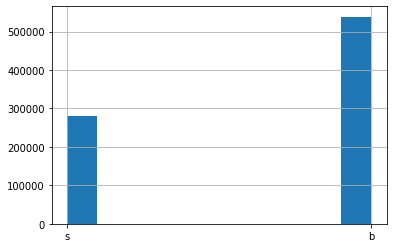

In [13]:
higgs['Label'].hist()
plt.show()

Tomamos los valores de esos atributos como un arreglo de NumPy. Convertimos los valores s y b de la columna `Label` a 0 y 1 respectivamente.

In [14]:
X = higgs[features].to_numpy()
y = np.zeros(len(higgs['Label'].to_numpy())).astype(int)
y[higgs['Label'].to_numpy() == 's'] = 1

Dividimos el conjunto completo en subconjuntos de entrenamiento y prueba.

In [15]:
Xe, X_prueba, ye, y_prueba = train_test_split(X, 
                                              y, 
                                              test_size=0.3, 
                                              random_state=42)

Realizamos validación cruzada para regresión logística con distintos valores de $\lambda$ ($\alpha$ en la clase `LogisticRegression` de scikit-learn) usando el subconjunto de entrenamiento.

In [16]:
n_rep = 2
n_pliegues = 3

alfas = np.arange(start=0.005, stop=0.03, step=0.005)
aucs = np.zeros((alfas.shape[0], n_rep * n_pliegues))
accs = np.zeros((alfas.shape[0], n_rep * n_pliegues))
precs = np.zeros((alfas.shape[0], n_rep * n_pliegues))
recalls = np.zeros((alfas.shape[0], n_rep * n_pliegues))
aps = np.zeros((alfas.shape[0], n_rep * n_pliegues))
for i,a in enumerate(alfas):
  for j, k, l, X_ent, y_ent, X_val, y_val in vcrep_kpart(Xe, ye, r=n_rep, k=n_pliegues):
    imp = SimpleImputer(strategy='mean')
    imp.fit(X_ent)
    X_ent = imp.transform(X_ent)

    sc = StandardScaler()
    X_ent = sc.fit_transform(X_ent)
    
    m = SGDClassifier(loss='log', penalty='l1', alpha=0.0002)
    m = m.fit(X_ent, y_ent)  

    X_val = imp.transform(X_val)
    X_val = sc.transform(X_val)
    y_pred = m.predict(X_val)
    probs = m.predict_proba(X_val)
    
    rvps, rfps = roc(probs[:, 1], y_val)
    aucs[i, l] = aucroc(rfps, rvps)
    accs[i, l] = accuracy_score(y_val, y_pred)
    precs[i, l] = precision_score(y_val, y_pred)
    recalls[i, l] = recall_score(y_val, y_pred)
    aps[i, l] = average_precision_score(y_val, y_pred)

Calculamos los promedios y desviaciones estándar de las métricas para cada valor de $\alpha$.

In [17]:
for i,a in enumerate(alfas):
  print(f'Alfa = {a}')
  print(f'\tAUC = {aucs[i,:].mean()} ({aucs[i,:].std()})')
  print(f'\tACC = {accs[i,:].mean()} ({accs[i,:].std()})')
  print(f'\tPREC = {precs[i,:].mean()} ({precs[i,:].std()})')
  print(f'\tRECALL = {recalls[i,:].mean()} ({recalls[i,:].std()})')
  print(f'\tAP = {aps[i,:].mean()} ({aps[i,:].std()})')

Alfa = 0.005
	AUC = 0.8133585779405527 (0.0014805724409014465)
	ACC = 0.7532308132815145 (0.0013544352349087261)
	PREC = 0.6750986095358978 (0.002572758277413222)
	RECALL = 0.5348470499113093 (0.013005721491429431)
	AP = 0.5199008690093686 (0.004184373810262794)
Alfa = 0.01
	AUC = 0.8117378854300532 (0.0007724131801954485)
	ACC = 0.7528676632342003 (0.0006056408247484852)
	PREC = 0.6719297693524701 (0.006296461270751935)
	RECALL = 0.5405176482817672 (0.014256910551212145)
	AP = 0.5200203181535665 (0.0015424783830961968)
Alfa = 0.015
	AUC = 0.8134623250430294 (0.0009538428533979152)
	ACC = 0.753623643861542 (0.0007350068538709866)
	PREC = 0.6757296052935162 (0.006384929926401081)
	RECALL = 0.5360917336804886 (0.01609594238488627)
	AP = 0.5205889744187138 (0.0027361205970986477)
Alfa = 0.02
	AUC = 0.8118560442935512 (0.0007364171152932831)
	ACC = 0.7524477709919931 (0.0010309502066126995)
	PREC = 0.6762452827656414 (0.003598560059678919)
	RECALL = 0.5279570590148451 (0.008287684824986643

Dibujamos los diagramas de caja de los valores AUC de cada valor de $\alpha$.

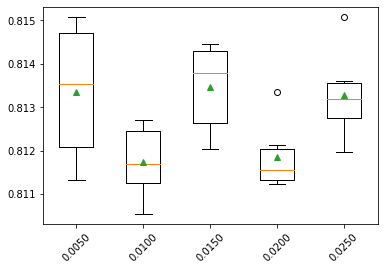

In [18]:
plt.boxplot(aucs.T, showmeans=True)
plt.xticks(range(1, len(alfas) + 1), [f'{a:.4f}' for a in alfas], rotation=45)
plt.show()

Seleccionamos el valor de $\alpha$ más apropiado, entrenamos un modelo con ese valor usando todo el subconjunto de entrenamiento y obtenemos las métricas de desempeño en el conjunto de prueba.

In [19]:
imp = SimpleImputer(strategy='mean')
imp.fit(Xe)
Xe = imp.transform(Xe)

sc = StandardScaler()
Xe = sc.fit_transform(Xe)
  
m = SGDClassifier(loss='log', 
                  penalty='l1', 
                  alpha=0.0006)
m = m.fit(Xe, ye)  

X_prueba = imp.transform(X_prueba)
X_prueba = sc.transform(X_prueba)
y_pred = m.predict(X_prueba)
probs = m.predict_proba(X_prueba)

rvps, rfps = roc(probs[:, 1], y_prueba)
print(f'AUC = {aucroc(rfps, rvps)}')
print(f'ACC = {accuracy_score(y_prueba, y_pred)}')
print(f'Prec = {precision_score(y_prueba, y_pred)}')
print(f'Recall = {recall_score(y_prueba, y_pred)}')
print(f'AP = {average_precision_score(y_prueba, y_pred)}')

AUC = 0.8125980979669544
ACC = 0.7531449615434754
Prec = 0.6773669425252449
Recall = 0.5313196040830425
AP = 0.5201976773978978


Graficamos la curva ROC.

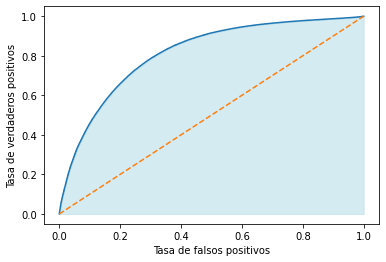

In [20]:
plt.plot(rfps, rvps)
plt.plot([0, 1], [0, 1], '--')
plt.fill_between(rfps, rvps, 0, alpha=0.5, color = 'lightblue')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.show()

Visualizamos el valor de los parámetros del modelo.

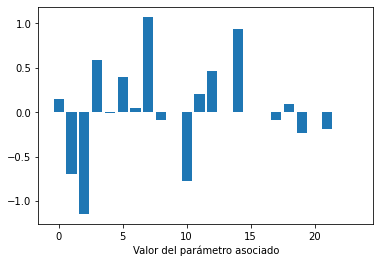

In [21]:
plt.bar(range(m.coef_[0].size), height=m.coef_[0])
plt.xlabel(u'Característica')
plt.xlabel(u'Valor del parámetro asociado')
plt.show()